In [2]:
#Load all required packages
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.correlation import plot_corr
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,make_scorer

In [3]:
# load training data and test data
train_df = pd.read_csv('Train_Zindi.csv', index_col=0)
test_df = pd.read_csv('Test_Zindi.csv', index_col=0)
riders_df = pd.read_csv('Riders_Zindi.csv', index_col=0)
sub_sample = pd.read_csv('SampleSubmission_Zindi.csv',index_col=0)

In [5]:
#Function to convert time rows to seconds after midnight
def time_fn(row):
    b = row.split(' ')
    if b[1] == 'AM':
        c = 0
    else:
        c = 12
    b = b[0].split(':')
    b = [int(i) for i in b]
    if b[0] == 12:
        c -= 12
    # convertion to minutes
    b[0] = (b[0] + c)*60*60
    b[1] = (b[1])*60
    row = sum(b)
    return(row)

In [6]:
#Convertion of times to seconds past midnight:
train_df['Placement - Time'] = train_df['Placement - Time'].apply(lambda x:time_fn(x))
train_df['Confirmation - Time'] = train_df['Confirmation - Time'].apply(lambda x:time_fn(x))
train_df['Arrival at Pickup - Time'] = train_df['Arrival at Pickup - Time'].apply(lambda x:time_fn(x))
train_df['Pickup - Time'] = train_df['Pickup - Time'].apply(lambda x:time_fn(x))
train_df['Arrival at Destination - Time'] = train_df['Arrival at Destination - Time'].apply(lambda x:time_fn(x))

In [7]:
# Remove rows where placement_day != confirmation day and pickup_day
train_df = train_df.drop(train_df[(train_df.iloc[:,4] != train_df.iloc[:,7]) | (train_df.iloc[:,7] != train_df.iloc[:,16])].index)

In [5]:
for i,v in enumerate(train_df.columns):
    print(i,v)

0 User Id
1 Vehicle Type
2 Platform Type
3 Personal or Business
4 Placement - Day of Month
5 Placement - Weekday (Mo = 1)
6 Placement - Time
7 Confirmation - Day of Month
8 Confirmation - Weekday (Mo = 1)
9 Confirmation - Time
10 Arrival at Pickup - Day of Month
11 Arrival at Pickup - Weekday (Mo = 1)
12 Arrival at Pickup - Time
13 Pickup - Day of Month
14 Pickup - Weekday (Mo = 1)
15 Pickup - Time
16 Arrival at Destination - Day of Month
17 Arrival at Destination - Weekday (Mo = 1)
18 Arrival at Destination - Time
19 Distance (KM)
20 Temperature
21 Precipitation in millimeters
22 Pickup Lat
23 Pickup Long
24 Destination Lat
25 Destination Long
26 Rider Id
27 Time from Pickup to Arrival


In [8]:
# Check if any values on the various times are anomalous
train_df = train_df[(train_df['Placement - Time'] < train_df['Confirmation - Time'])\
|(train_df['Arrival at Pickup - Time'] < train_df['Pickup - Time'])\
|(train_df['Pickup - Time'] < train_df['Arrival at Destination - Time'])]

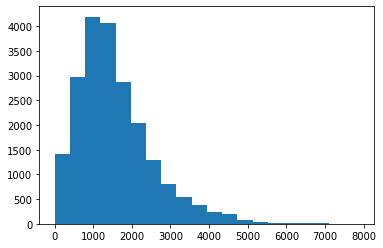

In [7]:
#Histogram of the distribution of the response
plt.hist(train_df['Time from Pickup to Arrival'],bins = 20)
plt.show()

In [9]:
#Based on histogram above the outliers can be removed(...so far they were chosen abitrarily)
train_df = train_df.drop(train_df[train_df['Time from Pickup to Arrival'] < 500].index)
train_df = train_df.drop(train_df[train_df['Time from Pickup to Arrival'] > 5000].index)

In [9]:
#Join train_df with riders dataframe
# train_df = pd.merge(train_df,riders_df,how='left',on=['Rider Id','Rider Id'])

In [10]:
# Choose model_features and model target(Note 'Arrival at destination is dropped')
X = train_df.loc[:,['Platform Type',\
                    'Personal or Business',\
                    'Placement - Day of Month',\
                    'Placement - Weekday (Mo = 1)',\
                    'Placement - Time',\
                    'Confirmation - Time',\
                    'Arrival at Pickup - Time',\
                    'Pickup - Time',\
                    'Distance (KM)',\
                    'Temperature',\
                    'Precipitation in millimeters',\
#                     'No_Of_Orders',\
#                     'Age',\
#                     'Average_Rating',\
#                     'No_of_Ratings'
                   ]]
Y = train_df.loc[:,'Time from Pickup to Arrival']

In [11]:
# Impute Null Temperature values with average temperature
imputing_col = ['Temperature','Precipitation in millimeters']
imputer_avg = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer_zero = SimpleImputer(missing_values = np.nan, strategy = 'constant',fill_value = 0)
for col in imputing_col:
    if col == 'Temperature':
        X[col] = imputer_avg.fit_transform(X.loc[:,[col]])
    else:
        X[col] = imputer_zero.fit_transform(X.loc[:,[col]]) 

In [12]:
# One-Hot Encode nominal categories
categorical_columns = ['Platform Type','Personal or Business','Placement - Weekday (Mo = 1)','Placement - Day of Month']
OH_X = pd.get_dummies(X,columns = categorical_columns)

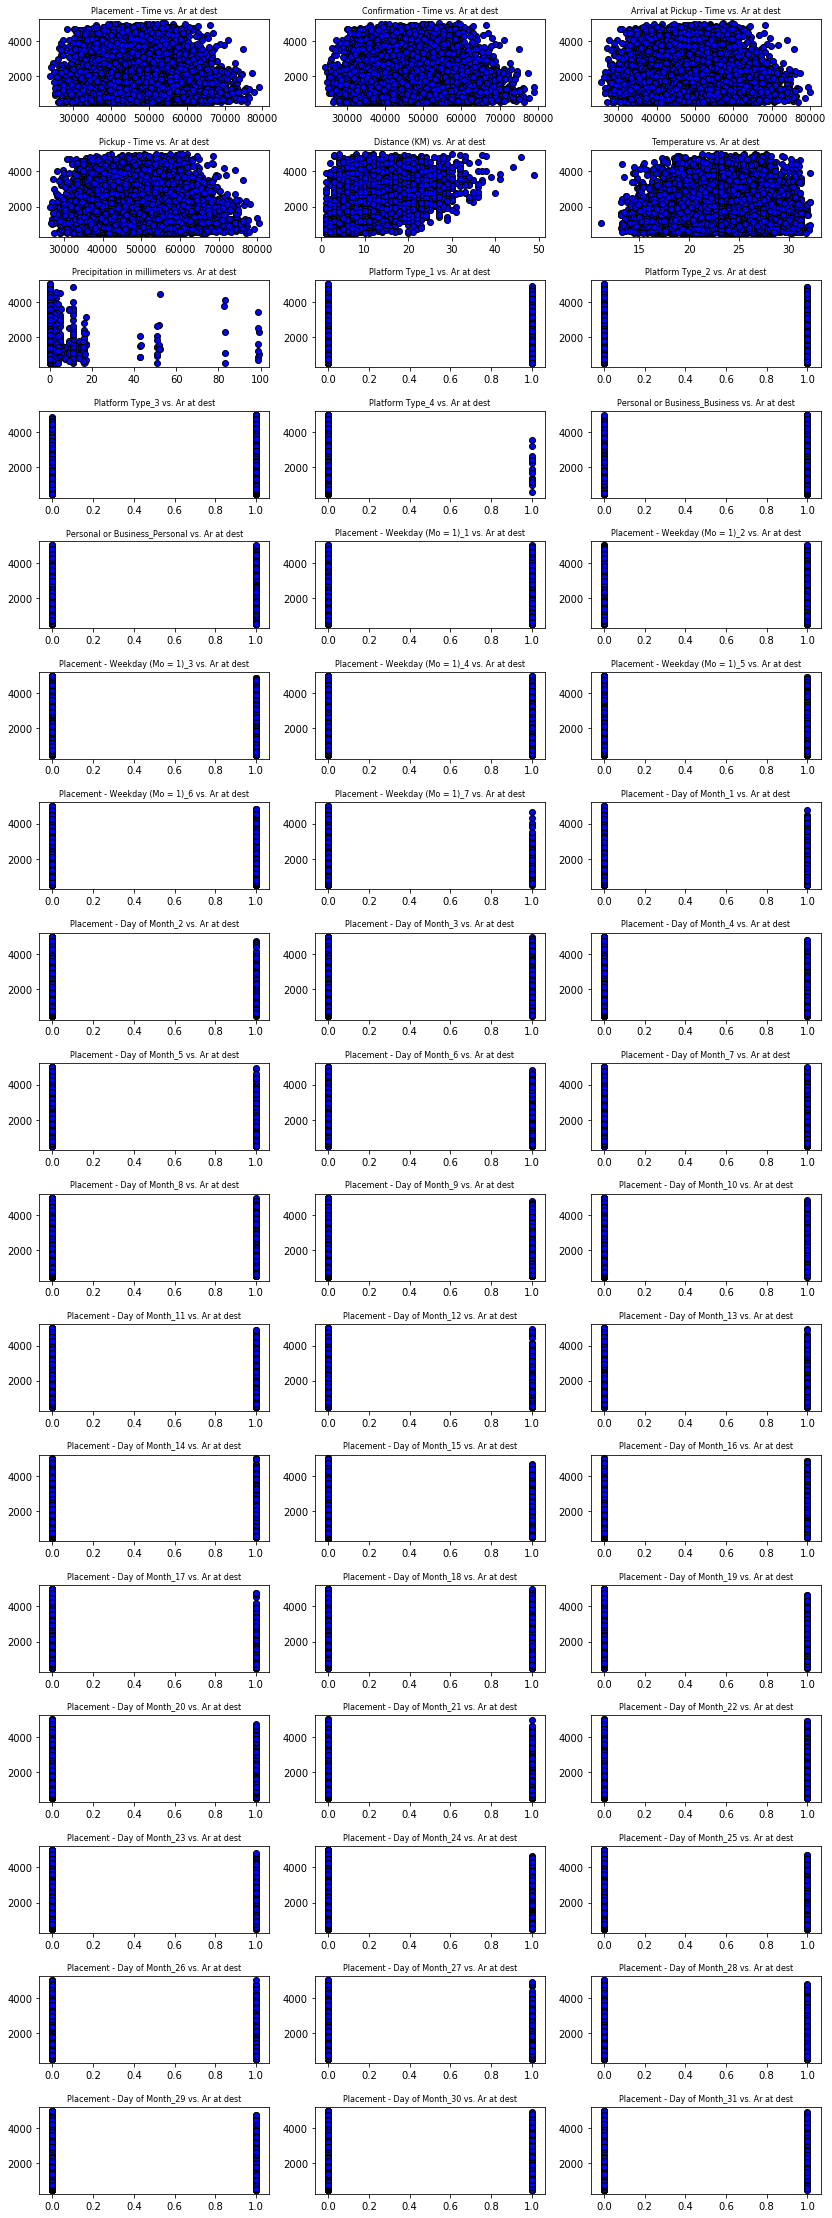

In [59]:
# Check for linearity
fig, axs = plt.subplots(17,3, figsize=(14,40),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()

for index, column in enumerate(OH_X.columns):
    axs[index].set_title("{} vs. Ar at dest".format(column),fontsize=8)
    axs[index].scatter(x=OH_X[column],y=Y,c='blue',edgecolor='k')

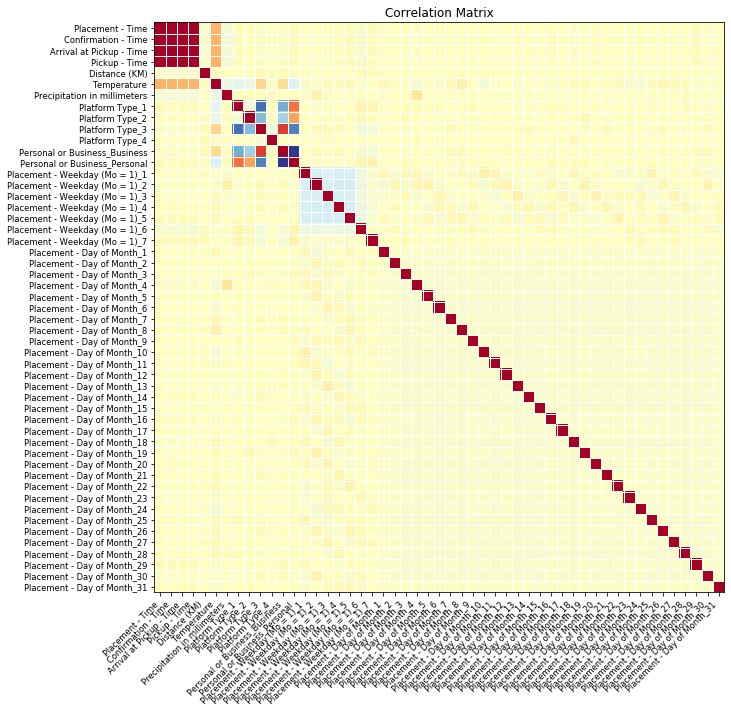

In [18]:
#check for collinear variables
corr = OH_X.corr()
fig, axz = plt.subplots(1,1, figsize=(14, 10))
fig = plot_corr(corr,xnames=corr.columns,ax=axz)

In [13]:
# Separate data into training, test data and validation data
X_train,X_test,Y_train,Y_test = train_test_split(OH_X,Y, test_size =0.2, random_state = 42)

In [20]:
# # Feature Scaling (Feature scale numeric data on training set)
# sc = StandardScaler()
# numeric_columns = ['Placement - Time',\
#                     'Confirmation - Time',\
#                     'Arrival at Pickup - Time',\
#                     'Pickup - Time',\
#                     'Distance (KM)',\
#                     'Temperature',\
# #                     'No_Of_Orders',\
# #                     'Age',\
# #                     'Average_Rating',\
# #                     'No_of_Ratings'
#                   ]
# X_train.loc[:,numeric_columns] = sc.fit_transform(X_train.loc[:,numeric_columns])

In [14]:
# Import REGRESSION MODEL and Train Model
from sklearn.linear_model import LinearRegression
LM_model = LinearRegression()
LM_model.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
#Test RMSE calculation
Y_pred =LM_model.predict(X_test)
mse_test = mean_squared_error(Y_test, Y_pred)
rmse_test = math.sqrt(mse_test)
#Training RMSE calculation
Y_pred_train = LM_model.predict(X_train)
mse_train = mean_squared_error(Y_train, Y_pred_train)
rmse_train = math.sqrt(mse_train)
#Validation RMSE calculation
Y_pred_val = LM_model.predict(X_val)
mse_val = mean_squared_error(Y_val,Y_pred_val)
rmse_val = math.sqrt(mse_val)

In [23]:
print('train rmse: ' + str(rmse_train))
print('test rmse: ' + str(rmse_test))
print('val rmse: ' + str(rmse_val))

train rmse: 707.9649841298815
test rmse: 718.4162000350242
val rmse: 688.8683625599709


In [24]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 50,max_depth = 10)
rfr.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [25]:
#Test RMSE calculation
Y_pred =rfr.predict(X_test)
mse_test = mean_squared_error(Y_test, Y_pred)
rmse_test = math.sqrt(mse_test)
#Training RMSE calculation
Y_pred_train = rfr.predict(X_train)
mse_train = mean_squared_error(Y_train, Y_pred_train)
rmse_train = math.sqrt(mse_train)
#Validation RMSE calculation
Y_pred_val = rfr.predict(X_val)
mse_val = mean_squared_error(Y_val,Y_pred_val)
rmse_val = math.sqrt(mse_val)

In [26]:
print('train rmse: ' + str(rmse_train))
print('test rmse: ' + str(rmse_test))
print('val rmse: ' + str(rmse_val))

train rmse: 623.7412832879452
test rmse: 732.5694681901624
val rmse: 701.2427448031117


In [ ]:
#K_fold validation
from sklearn.model_selection import KFold
#Create KFold Object
kf = KFold(n_splits = 6, shuffle = True, random_state = 42)

#Create Splits
splits = kf.split(X)
accuracy_rfr = []
accuracy_LM = []
for train_index, val_index in splits:
    training_in = len(train_index)
    val_in = len(val_index)
    #set up training data
    X_train, Y_train = X.iloc[train_index,:], Y[train_index]
    #set up validation data
    X_val, Y_val = X.iloc[val_index,:],Y[val_index]
    predictions = rfr.predict(X_val)
    accuracy_rfr.append(math.sqrt(mean_squared_error(Y_val, predictions)))
    predictions = LM_model.predict(X_val)
    accuracy_LM.append(math.sqrt(mean_squared_error(Y_val, predictions)))
print((np.array(accuracy_LM)).mean())
print((np.array(accuracy_rfr)).mean())

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
rmse_scorer = make_scorer(mean_squared_error)
models =[LM_model,rfr]
for model in models:
    cv = np.sqrt(cross_val_score(estimator = model,X = OH_X, y = Y, cv = 6, scoring = rmse_scorer))
    cv = cv.mean()
    print(cv)

709.4695203845234
719.598927653687


In [18]:
output = pd.DataFrame({'Arrival at Destination - Time': LM_model.predict(X_sub_sample)},index = sub_sample.index)

NameError: name 'X_sub_sample' is not defined

In [21]:
test_df

,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,...,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
Order No,,,,,,,,,,,,,,,,,,,,,
Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,...,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,...,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,...,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,...,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,...,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Order_No_3612,User_Id_2587,Bike,3,Business,7,1,10:35:49 AM,7,1,10:37:04 AM,...,1,10:48:18 AM,5,24.8,NaN,-1.258414,36.804800,-1.288780,36.816831,Rider_Id_362
Order_No_7657,User_Id_3547,Bike,3,Business,10,3,2:59:42 PM,10,3,3:00:57 PM,...,3,3:21:44 PM,22,30.7,NaN,-1.276141,36.771084,-1.316098,36.913164,Rider_Id_669
Order_No_1969,User_Id_136,Bike,3,Business,5,3,2:45:12 PM,5,3,2:45:36 PM,...,3,3:07:52 PM,10,25.1,NaN,-1.301446,36.766138,-1.264960,36.798178,Rider_Id_379
